# Implementación del algoritmo Multiscale Morphological Contrast Enhancement (MMCE)

In [28]:
# Importación de librerías
import os
from os import listdir, path
import numpy as np
import cv2
from skimage.morphology import square, opening, closing
import matplotlib.pyplot as plt

In [10]:
# Primera versión de la función MMCE
def MMCE1(image, n):
    WTH = []
    BTH = []
    for i in range(1, n+1):
        se = square(2*i+1)
        WTH.append(image - opening(image, se))
        BTH.append(closing(image, se) - image)

    WTH_S = [WTH[i] - WTH[i-1] for i in range(1, n)]
    BTH_S = [BTH[i] - BTH[i-1] for i in range(1, n)]

    WTH_M = np.max(WTH, axis=0)
    BTH_M = np.max(BTH, axis=0)
    WTH_MS = np.max(WTH_S, axis=0)
    BTH_MS = np.max(BTH_S, axis=0)

    enhanced_image = image + (WTH_M + WTH_MS) - (BTH_M + BTH_MS)
    return enhanced_image

In [11]:
# Segunda versión de la función MMCE
def MMC2(image, n_iterations):
    """
    Función que implementa el algoritmo de Mejora de Contraste por Morfología
    de Contraste Máximo (MMCE)

    Parámetros:
    image: Imagen de entrada en escala de grises.
    n_iterations: Número de iteraciones a realizar.

    Retorna:
    enhanced_image: Imagen con aumento de contraste.
    """
    # Primera etapa del algoritmo: Obtener escalas de brillo y oscuridad
    scales = [cv2.getStructuringElement(cv2.MORPH_RECT, (2*i+1, 2*i+1)) for i in range(1, n_iterations+1)]
    WTH_scales = [cv2.subtract(image, cv2.morphologyEx(image, cv2.MORPH_TOPHAT, scale)) for scale in scales]
    BTH_scales = [cv2.subtract(cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, scale), image) for scale in scales]
    
    # Segunda etapa del algoritmo: Obtener sustracciones de escalas
    WTH_diff_scales = [cv2.subtract(WTH_scales[i], WTH_scales[i-1]) for i in range(1, len(WTH_scales))]
    BTH_diff_scales = [cv2.subtract(BTH_scales[i], BTH_scales[i-1]) for i in range(1, len(BTH_scales))]
    
    # Tercera etapa del algoritmo: Calcular máximos valores
    WTH_max_scale = max(WTH_scales, key=np.max)
    BTH_max_scale = max(BTH_scales, key=np.max)
    WTH_diff_max_scale = max(WTH_diff_scales, key=np.max)
    BTH_diff_max_scale = max(BTH_diff_scales, key=np.max)
    
    # Etapa final: Obtener la imagen con aumento de contraste
    enhanced_image = cv2.add(cv2.subtract(cv2.add(image, WTH_max_scale), BTH_max_scale), cv2.subtract(WTH_diff_max_scale, BTH_diff_max_scale))
    
    return enhanced_image

In [35]:
# Tercera versión de la función MMCE
def mmce3(image, n=3, gamma=1.2, beta=2.0):
  # Normalizar la imagen a valores entre 0 y 1
    
    """
  Implementación del algoritmo MMCE para mejorar el contraste de la imagen.

  Args:
    image: Imagen de entrada (en escala de grises).
    n: Número de iteraciones para la extracción de características multiescala.
    gamma: Parámetro que controla la intensidad del realce de contraste.
    beta: Parámetro que controla la suavidad del realce de contraste.

  Returns:
    Imagen mejorada.
  """
    image = image / 255.0
    # Aplicar la transformación top-hat multiescala
    enhanced_image = []
    for k in range(n):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        filtered_image = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
        enhanced_image.append(filtered_image)

    # Combinar las características de imagen multiescala
    enhanced_image = np.array(enhanced_image).mean(axis=0)

    # Aplicar la función de transformación de contraste
    enhanced_image = np.power(enhanced_image, gamma) * beta
    # Limitar los valores entre 0 y 1
    enhanced_image = np.clip(enhanced_image, 0, 1)
    # Convertir la imagen mejorada al formato de salida
    enhanced_image = enhanced_image * 255.0
    enhanced_image = enhanced_image.astype(np.uint8)
    return enhanced_image

In [13]:
# Función para la lectura de imágenes

def read_images(directory, allow_color_images=False):
    """
    Lee todas las imágenes en un directorio

    Parámetros

    directory: str
        Directorio con las imágenes
    allow_color_images: bool
        Permite el uso de imágenes a color

    Retorna

    images: list
        Lista con las imágenes
    """
    # Leer todas las imágenes en el directorio
    images = []
    for f in listdir(directory):
        if f.endswith('.jpg') or f.endswith('.png'):
            image = cv2.imread(path.join(directory, f), cv2.IMREAD_GRAYSCALE)
            if allow_color_images:
                image = cv2.imread(path.join(directory, f), cv2.IMREAD_COLOR)
            images.append(image)
    return images

In [24]:
# Ruta de las imágenes
image_path = "E:/Panel_30W/P13/V24.2_I2.50_t30/JPEG_8"
#background_path ="E:/Panel_30W/P13/V24.2_I2.50_t30/fondo_8/JPEG_fondo_8"
No_background_path = "E:/Panel_30W/Salida13/P8/dataset_noBG"
imagePP_path = "E:/Panel_30W/Salida13/P8bg"
#image1_2Isc_path = "E:/Panel_30W/P13/V22.1_I0.9_t27.973/JPEG"

datasetEL = read_images(image_path)
#datasetBG = read_images(background_path)
dataset_noBG = read_images(No_background_path)
datasetPP = read_images(imagePP_path)

# Imprime el número de imágenes en cada dataset
# para probar que las imágenes se agregaron
print("Imágenes en el dataset EL: ", len(datasetEL))
#print("Imágenes en el dataset BG: ", len(datasetBG))
#print("Imágenes en el dataset noBG: ", len(dataset_noBG))
print("Imágenes en el dataset PP: ", len(datasetPP))

Imágenes en el dataset EL:  51
Imágenes en el dataset PP:  5


In [31]:
#Evaluación de la primera versión de la función MMCE

image_test = datasetEL[0]
image_enhanced = MMCE1(image_test, 7) 
cv2.imshow("Original", image_test)
cv2.imshow("Mejorada", image_enhanced)
cv2.waitKey(0)

-1

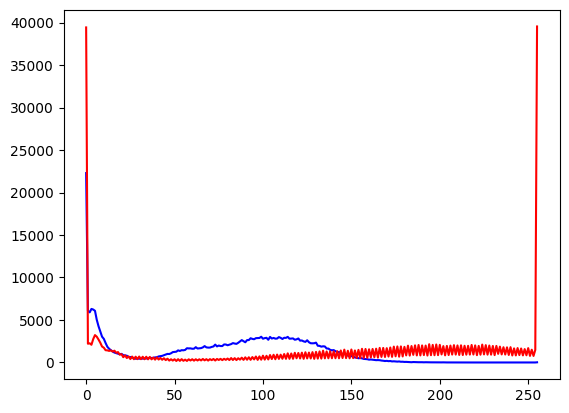

-1

In [30]:
# Evaluación de la segunda versión de la función MMCE

image_test = datasetEL[0]

image_enhanced = MMC2(image_test, 8)
original_hist = cv2.calcHist([image_test], [0], None, [256], [0, 256])
enhanced_hist = cv2.calcHist([image_enhanced], [0], None, [256], [0, 256])
# Mostrar el instograma de la imagen original y el mejorada
plt.plot(original_hist, color='b')
plt.plot(enhanced_hist, color='r')
plt.show()

cv2.imshow("Original", image_test)
cv2.imshow("Mejorada", image_enhanced)
cv2.waitKey(0)


In [36]:
# Evaluación de la tercera versión de la función MMCE

image_test = datasetEL[0]
image_enhanced = mmce3(image_test, 3)
cv2.imshow("Original", image_test)
cv2.imshow("Mejorada", image_enhanced)
cv2.waitKey(0)

-1

In [44]:
# Aplicación de la función MMCE2 a todas las imágenes en el dataset y luego obtener la media de las imágenes mejoradas
enhanced_images = []
for image in datasetEL:
    enhanced_image = MMC2(image, 7)
    enhanced_images.append(enhanced_image)
enhanced_images = np.min(enhanced_images, axis=0)


# comparación de la imagen original (datasetEL[0]) con la imagen mejorada (enhanced_images)

cv2.imshow("Original", datasetEL[0])
cv2.imshow("Mejorada min del dataset", enhanced_images)
cv2.waitKey(0)



-1